In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mygrad.components as mc
import mygrad.functional as mf
from mygrad.losses import BinaryCrossEntropy, CategorialCorssEntropy, MeanSquareErrorLoss
from mygrad.optimizers import SGD
from mygrad.preprocessors import MinMaxScaler, StandardScaler
from mygrad.trainers import BinaryClassificationTrainer, CategoricalClassificationTrainer, ProgressBar, Trainer as RegressionTrainer, Plugin
from mygrad.dataloaders import NumpyRegressionDataloader, NumpyClassificationDataloader

/tmp/ipykernel_25267/4244958111.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Easy

In [2]:
train_df = pd.read_csv("../mio1/classification/easy-training.csv")
test_df = pd.read_csv("../mio1/classification/easy-test.csv")

Text(0.5, 1.0, 'Wizualizacja zbioru treningowego Easy')

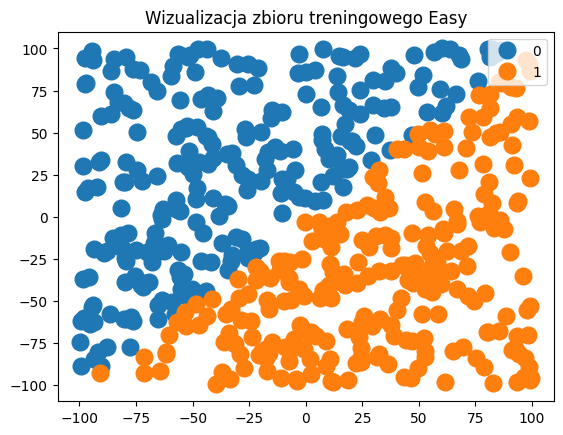

In [3]:
groups = train_df.groupby('c')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name * 1)

plt.legend(loc="upper right")
plt.title("Wizualizacja zbioru treningowego Easy")

In [4]:
X_train = train_df[["x", "y"]].values
y_train = train_df["c"].values.reshape(-1, 1) * 1

In [5]:
X_train.shape, y_train.shape

((500, 2), (500, 1))

In [6]:
input_normalizer = StandardScaler()

X_train_scaled = input_normalizer.fit_transform(X_train)

In [7]:
model = mc.Sequential(
    mc.Linear(2, 10, init="xavier"),
    mc.Tanh(),
    mc.Linear(10, 1, init="xavier")
)
optimizer = SGD(model.parameters(), learning_rate=0.02, momentum=0.9, dampening=0.9)
loss = MeanSquareErrorLoss()

train_dataloader = NumpyRegressionDataloader(X_train_scaled, y_train, batch_size=100, shuffle=True)
trainer = BinaryClassificationTrainer(model, optimizer, loss, train_dataloader, plugins=[ProgressBar()])
train_outputs_bin = trainer.train(100)

Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/home/zetrext/Code/MIOwAD/mygrad/mygrad/functional.py:47: RuntimeWarning: invalid value encountered in divide
  recall = tp / np.sum(y_true, axis=0)


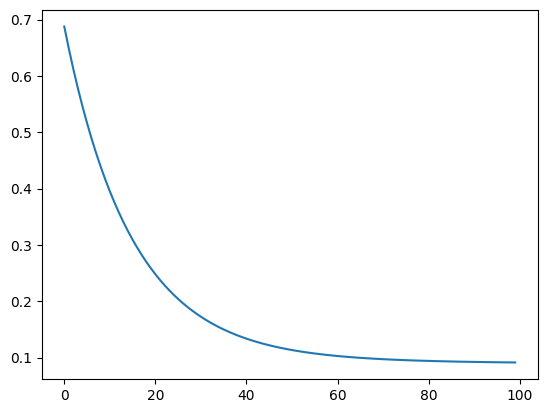

In [8]:
plt.plot(train_outputs_bin["loss"])

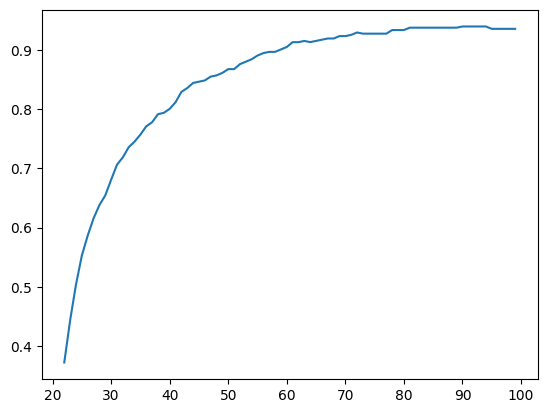

In [9]:
plt.plot(train_outputs_bin["fscore"])

In [10]:
X_test = test_df[["x", "y"]].values
y_test = test_df["c"].values.reshape(-1, 1) * 1

X_test_scaled = input_normalizer.transform(X_test)

y_pred_scaled = model.forward(X_test_scaled)
y_pred = (y_pred_scaled > 0.5) * 1

print(f"F-score: {mf.fscore(y_pred, y_test, 2)}")


F-score: 0.9358974358974359


# SOFTMAX

In [11]:
model = mc.Sequential(
    mc.Linear(2, 10, init="xavier"),
    mc.Tanh(),
    mc.Linear(10, 2, init="xavier"),
    mc.Softmax()
)
optimizer = SGD(model.parameters(), learning_rate=0.02, momentum=0.9, dampening=0.9)
loss = CategorialCorssEntropy()

y_train_onehot = mf.onehot_encode(y_train, 2)

train_dataloader = NumpyClassificationDataloader(X_train_scaled, y_train_onehot, batch_size=100, shuffle=True, is_one_hot=True)
trainer = CategoricalClassificationTrainer(model, optimizer, loss, train_dataloader, plugins=[ProgressBar()])
train_outputs_cat = trainer.train(100)

Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

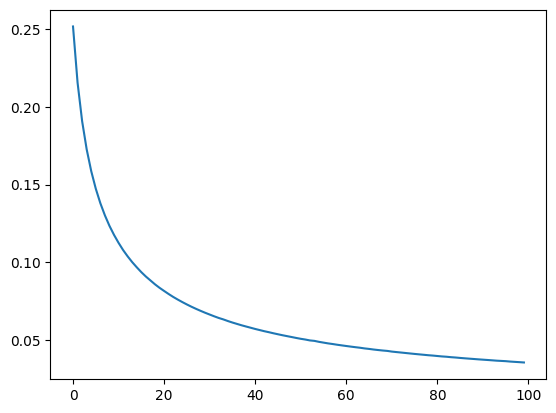

In [12]:
plt.plot(train_outputs_cat["loss"])

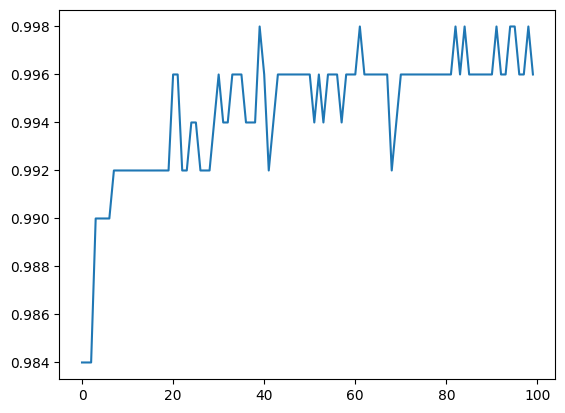

In [13]:
plt.plot(train_outputs_cat["fscore"])

Text(0.5, 1.0, 'Porównanie F1 Score\npodczas trenowania dla obu modeli na zbiorze Easy')

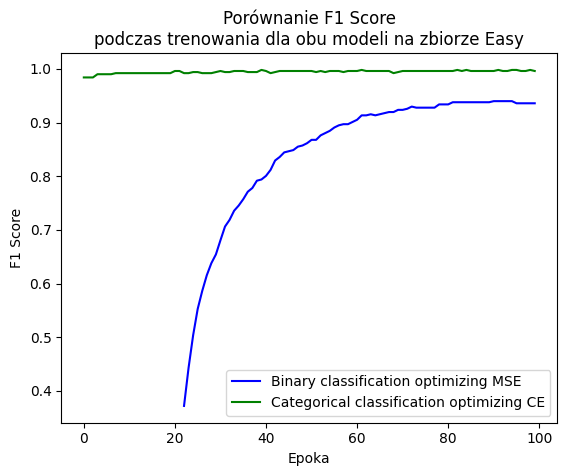

In [14]:
plt.plot(train_outputs_bin["fscore"], "b", label = "Binary classification optimizing MSE")
plt.plot(train_outputs_cat["fscore"], "g", label = "Categorical classification optimizing CE")
plt.legend()
plt.xlabel("Epoka")
plt.ylabel("F1 Score")
plt.title("Porównanie F1 Score\npodczas trenowania dla obu modeli na zbiorze Easy")

Text(0.5, 1.0, 'Wizualizacja zbioru testowego easy')

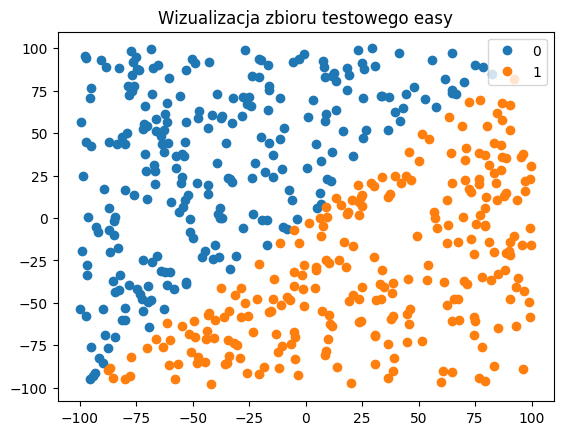

In [20]:
groups = test_df.groupby('c')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=6, label=name*1)

plt.legend(loc="upper right")
plt.title("Wizualizacja zbioru testowego easy")

Text(0.5, 1.0, 'Wizualizacja poprawności predykcji na zbiorze easy')

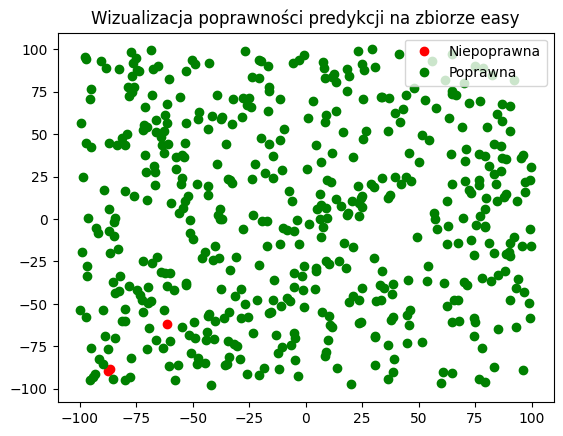

In [21]:
y_pred = model.forward(X_test_scaled)
y_pred = mf.onehot_decode(y_pred)

compare_df = pd.DataFrame(X_test, columns=["x", "y"])
compare_df["c"] = y_pred == y_test.flatten()

groups = compare_df.groupby('c')
for name, group in groups:
    if name:
        plt.plot(group.x, group.y, marker='o', linestyle='', markersize=6, color="green", label="Poprawna")
    else:
        plt.plot(group.x, group.y, marker='o', linestyle='', markersize=6, color="red", label="Niepoprawna")


plt.legend(loc="upper right")
plt.title("Wizualizacja poprawności predykcji na zbiorze easy")